In [405]:
#import folium
import os
import pandas as pd
import lxml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

In [2]:
# # Sample code
# # Coordinates for Bangladesh
# bd_coordinates = (23.685, 90.356)

# # Create a map centered around Bangladesh with OpenStreetMap tileset
# bd_map = folium.Map(location=bd_coordinates, zoom_start=7, tiles='OpenStreetMap')

# # Custom icon for the bridges
# icon = folium.Icon(color="blue", icon="info-sign")

# # Coordinates of important bridges in Bangladesh
# bridges = {
#     "Padma Bridge": (23.8251, 90.3686),
#     "Bangabandhu Bridge": (24.0794, 89.6529),
#     "Jamuna Bridge": (24.4366, 89.8930),
#     "Meghna Bridge": (23.0238, 90.7287)
# }

# # Add markers for each bridge with customized icons
# for bridge, coords in bridges.items():
#     folium.Marker(location=coords, popup=bridge, icon=icon).add_to(bd_map)

# # Display the map
# bd_map



To Do

@Lukas
>add additional datafiles to git
>Code uit assignment 3 invoegen invoegen
>dataframe met benodigde wegen maken
> try to merge rmms data with bmms

@timon en @fred
>htm bestanden uit datafolder inlezen
>data uit htm bestand scrapen
>pd.read_htm , 5th element is the table
> read in all vehicles types
> split vehicles into cargo and non-cargo


@bram if lukas not succesfull try via aggregating
>combine bridge df and traffic flow df (via chainage)



Hoe moet het er uiteindelijk uit zien?
>criticality: simple traffic flow (broken down into Heavy Truck, Medium Truck, Small Truck)
> vulnerability: quality col from bmms df + bridge length
> Quality ordinal variable, bridge length


Outputs/ plot:
>choropleths of traffic flow data
> 


# RMMS

## Functions for importing RMMS

First, let us define a function to find the RMMS folder location.

In [244]:
def get_rmms_relative_path():
    # Get the current working directory
    current_directory = os.getcwd()

    # Navigate one folder up
    parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))

    # Go inside the "data" folder
    data_folder = os.path.join(parent_directory, 'data')

    # Go inside the "RMMS" folder
    rmms_folder = os.path.join(data_folder, 'RMMS')

    # Print the relative path
    relative_path = os.path.relpath(rmms_folder, start=current_directory)
    
    return relative_path


In [245]:
# Test for the correct folder:
relative_path_to_rmms = get_rmms_relative_path()
print(relative_path_to_rmms)

..\data\RMMS


In [246]:
def read_htm_file(folder_path, file_name):
    # Construct the full path to the HTM file
    file_path = os.path.join(folder_path, file_name)
    
    # Read the HTM file and extract components of the file
    components = pd.read_html(file_path)
    
    # Assuming the table we want is the fifth one, access the fourth index
    desired_table = components[4]
    
    # Drop the title row - not necessary
    desired_table = desired_table.drop(index=0)
    
    # Reset the index after dropping the title row
    desired_table = desired_table.reset_index(drop=True)
    
    # Now return with the desired_table DataFrame
    return desired_table

In [255]:
# Read first htm from the folder
lukasdf = read_htm_file(relative_path_to_rmms, "N1.traffic.htm")
lukasdf.head(3)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,Link no,Name,Start location,Start location,Start location,End location,End location,End location,Length,Traffic Data,...,Traffic Data,Traffic Data,Traffic Data,Traffic Data,Traffic Data,Traffic Data,Total,Total,Total,Traffic
1,NaN,NaN,LRP,Offset,Chainage,LRP,Offset,Chainage,(Km),Heavy Truck,...,Car,Auto Rickshaw,Motor Cycle,Bi-Cycle,Cycle Rickshaw,Cart,Motorized,Non Motorized,Total AADT,(AADT)
2,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0,LRPS,822,0.822,0.822,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0


In [138]:
def create_multi_index(df):
    desired_table = df
    # Get the values of the first two rows
    first_row_values = desired_table.iloc[0].values
    second_row_values = desired_table.iloc[1].values

    # Combine the values from the first two rows into column names, avoiding concatenation if the second value is NaN
    column_names = []
    for first, second in zip(first_row_values, second_row_values):
        if isinstance(second, str) and not pd.isna(second):
            column_names.append(f'{first} - {second}')
        else:
            column_names.append(first)
    
    # Remove the first two rows
    desired_table = desired_table.drop([0, 1])
    
    # Reset the index after dropping these rows
    desired_table = desired_table.reset_index(drop=True)
    
    # Check if the number of columns matches the length of column names
    if len(desired_table.columns) == len(column_names):
        # Set the combined column names to the DataFrame
        desired_table.columns = column_names
    else:
        raise ValueError("Length of column names does not match the number of columns in the DataFrame.")
    
    # Return result
    return desired_table

In [256]:
lukasidf = create_multi_index(lukasdf)
lukasidf.head(3)

,Link no,Name,Start location - LRP,Start location - Offset,Start location - Chainage,End location - LRP,End location - Offset,End location - Chainage,Length - (Km),Traffic Data - Heavy Truck,...,Traffic Data - Car,Traffic Data - Auto Rickshaw,Traffic Data - Motor Cycle,Traffic Data - Bi-Cycle,Traffic Data - Cycle Rickshaw,Traffic Data - Cart,Total - Motorized,Total - Non Motorized,Total - Total AADT,Traffic - (AADT)
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0,LRPS,822,0.822,0.822,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0,LRPS,822,0.822,0.822,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0


## Importing all RMMS dataframes and merging

In [277]:
dfs = []

# Loop over all '.traffic' HTML files in the folder
for file_path in glob.glob(f"{relative_path_to_rmms}*/*.traffic.htm"):
    
    # Extract the file name from the file path
    file_name = os.path.basename(file_path)
    
    # Apply the previously defined funtions
    df = read_htm_file(relative_path_to_rmms, file_name)
    df_processed = create_multi_index(df)
    
    # Append the processed DataFrame to the list
    # This append is still alowed right? Because it appends something to a list? Or is that not true?
    dfs.append(df_processed)

rmms_concat = pd.concat(dfs, ignore_index=True)
rmms_concat

,Link no,Name,Start location - LRP,Start location - Offset,Start location - Chainage,End location - LRP,End location - Offset,End location - Chainage,Length - (Km),Traffic Data - Heavy Truck,...,Traffic Data - Car,Traffic Data - Auto Rickshaw,Traffic Data - Motor Cycle,Traffic Data - Bi-Cycle,Traffic Data - Cycle Rickshaw,Traffic Data - Cart,Total - Motorized,Total - Non Motorized,Total - Total AADT,Traffic - (AADT)
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0,LRPS,822,0.822,0.822,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0,LRPS,822,0.822,0.822,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822,0.822,LRPS,4175,4.175,3.353,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
4,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,91.0,...,1690.0,2266.0,1087.0,75.0,1198.0,0.0,16288.0,1273.0,17561.0,17561.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,N809-3,Dinerpool (Int.with Z8044)-Veduria Ferryghat,LRP003,2300,5.3,LRP025,675,25.69,20.390,0.0,...,22.0,380.0,596.0,275.0,441.0,0.0,1390.0,716.0,2106.0,2106.0
607,N809-4,Veduria Ferryghat-Parantalukderhat (Int.with R...,LRP025,675,25.69,LRP034,995,35.195,9.505,4.0,...,36.0,270.0,233.0,198.0,204.0,0.0,1153.0,402.0,1555.0,1555.0
608,N809-5,Parantalukderhat (Int.with R890)-Illisha Chata...,LRP034,995,35.195,LRP041,945,42.16,6.965,4.0,...,36.0,270.0,233.0,198.0,204.0,0.0,1153.0,402.0,1555.0,1555.0
609,N809-6,Maju Chowdhury Ghat-Terobaki (Int.with R147),LRP041,945,42.16,LRP066,82,66.177,24.017,0.0,...,56.0,251.0,173.0,177.0,167.0,0.0,905.0,344.0,1249.0,1249.0


# BMMS and Roads data
Here we will import ans use the BMMS and Roads data. Most of this originates from the previous assignments.

In [9]:
datapath = '../data'
roads_data = pd.read_csv(datapath+'/_roads3.csv')
bmms_data = pd.read_excel(datapath+'/BMMS_overview.xlsx')

In [153]:
roads = roads_data
bmms = bmms_data

In [350]:
bmms.head(3)

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.800,19.5,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.698739,90.458861,interpolate
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,35.4,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.694664,90.487775,interpolate
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.705060,90.523214,interpolate


In [300]:
#add: 
#filter on N-roads
#sort on Road name, and then on chainage

def clean_bmms0(df):
    df_return = df.loc[df['road'].str.startswith('N')]
    return df_return

def clean_bmms1(df):
    # Remove unnecessary columns
    columns_to_remove = ['structureNr', 'roadName', 'width', 'constructionYear',
                         'spans', 'zone', 'circle', 'division', 'sub-division','EstimatedLoc', 'km']
    df = df.drop(columns=columns_to_remove, errors='ignore')
    new_order_columns = ['road', 'LRPName', 'type', 'name', 'condition', 'length', 'chainage', 'lat', 'lon'] 
    df = df[new_order_columns]
    #df = df.sort_values(by='chainage').reset_index(drop=True)
    df = df.sort_values(by=['road', 'chainage']).reset_index(drop=True)

    #df['chainage'] *= 1000
    return df

def clean_bmms2(df, keep_method='first'):
    # Drop duplicate rows based on lon, lat, and LRPName
    return df.drop_duplicates(subset=['lon', 'lat', 'LRPName'], keep=keep_method).copy()

def clean_bmms3(df, keep_method='first'):
    # Filter rows based on name containing certain patterns and not being duplicated within first 6 characters
    condition = ~(df['name'].str.contains(r'\(\s*L\s*\)|\(\s*R\s*\)|\(Left\)|\(Right\)', case=False) & df['name'].str[:6].str.lower().duplicated(keep=keep_method))
    return df[condition].copy()

def clean_bmms4(df, keep_method='first'):
    # Create 'LRP' and 'length_rounded' columns, drop duplicates based on LRP, length_rounded, and lat
    df_return = df.copy()
    df_return['LRP'] = df_return['LRPName'].str[:6]
    df_return['length_rounded'] = df_return['length'].round(0)
    df_return = df_return.drop_duplicates(subset=['LRP', 'length_rounded', 'lat'], keep='first')
    
    df_return = df_return.drop(columns=['length_rounded', 'LRP'])
    return df_return.copy()

def clean_bmms5(df, keep_method='first'):
    # Drop duplicate rows based on lat
    return df.drop_duplicates(subset=['lat'], keep=keep_method).copy()

def run_bmms_clean(df):
    result = df.copy()
    for func in cleaning_functions:
        result = func(result)
    return result

In [349]:
bmms0= clean_bmms0(bmms)
bmms1=clean_bmms1(bmms0)
bmms2=clean_bmms2(bmms1)
bmms3=clean_bmms3(bmms2)
bmms4=clean_bmms4(bmms3)
bmms5=clean_bmms5(bmms4)
bmms5.head(4)

,road,LRPName,type,name,condition,length,chainage,lat,lon
0,N1,LRP001a,Box Culvert,.,A,11.30,1.800,23.698739,90.458861
1,N1,LRP004b,Box Culvert,.,A,6.60,4.925,23.694664,90.487775
2,N1,LRP008b,PC Girder Bridge,Kanch pur Bridge.,A,394.23,8.976,23.705060,90.523214
4,N1,LRP010a,Box Culvert,KATCHPUR BOX CULVERT,B,8.00,10.543,23.696400,90.535099


In [124]:
lukasidf.head(2)

,Link no,Name,Start location - LRP,Start location - Offset,Start location - Chainage,End location - LRP,End location - Offset,End location - Chainage,Length - (Km),Traffic Data - Heavy Truck,...,Traffic Data - Car,Traffic Data - Auto Rickshaw,Traffic Data - Motor Cycle,Traffic Data - Bi-Cycle,Traffic Data - Cycle Rickshaw,Traffic Data - Cart,Total - Motorized,Total - Non Motorized,Total - Total AADT,Traffic - (AADT)
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0,LRPS,822,0.822,0.822,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0,LRPS,822,0.822,0.822,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0


In [275]:
#Remove unnecessary columns, also rename remaining columns
def clean_rmms0(df):
    columns_to_drop = [
    'Start location - LRP',
    'Start location - Offset',
    'End location - LRP',
    'End location - Offset',
    'Traffic Data - Large Bus',
    'Traffic Data - Medium Bus',
    'Traffic Data - Micro Bus',
    'Traffic Data - Utility',
    'Traffic Data - Car',
    'Traffic Data - Auto Rickshaw',
    'Traffic Data - Motor Cycle',
    'Traffic Data - Bi-Cycle',
    'Traffic Data - Cycle Rickshaw',
    'Traffic Data - Cart',
    'Total - Motorized',
    'Total - Non Motorized',
    'Total - Total AADT']
    
    df = df.drop(columns=columns_to_drop, errors='ignore')
    
    column_rename_dict = {
    'Link no': 'Link number',
    'Name': 'Name',
    'Start location - Chainage': 'Chainage start',
    'End location - Chainage': 'Chainage end',
    'Length - (Km)': 'Length Km',
    'Traffic Data - Heavy Truck': 'Heavy truck',
    'Traffic Data - Medium Truck': 'Medium truck',
    'Traffic Data - Small Truck': 'Small truck',
    'Traffic - (AADT)': 'AADT'}
    
    df = df.rename(columns=column_rename_dict)
    return df

#change var type, add column which is a sum of heavy, medium and small truck data
def clean_rmms1(df):
    columns_change_var_type = column_list = ['Chainage start','Chainage end','Length Km','Heavy truck','Medium truck','Small truck','AADT']
    
    for col in columns_change_var_type:  # Select columns from 3rd to 12th
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

#Create the extra columns road name and sum of the disicted truck types
def clean_rmms2(df):
    df['Road name'] = df['Link number'].str.split('-').str.get(0)
    df['Sum Truck'] = df['Heavy truck'] + df['Medium truck'] + df['Small truck']
    return df

#aggregate rows which have a duplicate 'Chainage start' value. All non-float columns are aggregated via 'first', all float columns are aggregated
# via sum''. Meaning that 2 datapoints for the same measurement point are added to eachother.
def clean_rmms3(df):
    aggregation_functions = {
    'Link number': 'first',
    'Name': 'first',
    'Chainage start': 'first',
    'Chainage end': 'first',
    'Length Km': 'first',
    'Heavy truck': 'sum',
    'Medium truck': 'sum',
    'Small truck': 'sum',
    'AADT': 'sum',
    'Road name':'first',
    'Sum Truck':'sum' }
    
    aggregated_df = df.groupby(['Road name','Chainage start']).agg(aggregation_functions).reset_index(drop=True)#drop=True, inplace=True)

    return aggregated_df

In [348]:
rmms1.head(2)

,Link number,Name,Chainage start,Chainage end,Length Km,Heavy truck,Medium truck,Small truck,AADT,Road name,Sum Truck
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),0.0,0.822,0.822,402.0,5842.0,1147.0,19357.0,N1,7391.0
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),0.0,0.822,0.822,660.0,6155.0,1554.0,21537.0,N1,8369.0


In [347]:
rmms_concat.head(2)

,Link no,Name,Start location - LRP,Start location - Offset,Start location - Chainage,End location - LRP,End location - Offset,End location - Chainage,Length - (Km),Traffic Data - Heavy Truck,...,Traffic Data - Car,Traffic Data - Auto Rickshaw,Traffic Data - Motor Cycle,Traffic Data - Bi-Cycle,Traffic Data - Cycle Rickshaw,Traffic Data - Cart,Total - Motorized,Total - Non Motorized,Total - Total AADT,Traffic - (AADT)
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0,LRPS,822,0.822,0.822,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0,LRPS,822,0.822,0.822,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0


In [334]:
rmms0= clean_rmms0(rmms_concat)
rmms1= clean_rmms1(rmms0)
rmms2= clean_rmms2(rmms1)
rmms3= clean_rmms3(rmms2)
rmms3

,Link number,Name,Chainage start,Chainage end,Length Km,Heavy truck,Medium truck,Small truck,AADT,Road name,Sum Truck
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),0.000,0.822,0.822,1062.0,11997.0,2701.0,40894.0,N1,15760.0
1,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),0.822,4.175,3.353,1062.0,11997.0,2701.0,40894.0,N1,15760.0
2,N1-3L,Signboard - Shimrail (Left)R110 (Left),4.175,7.181,3.006,176.0,5250.0,4237.0,34218.0,N1,9663.0
3,N1-4L,Shimrail - Katchpur (Left)N2 (Left),7.181,8.763,1.582,327.0,5860.0,2926.0,35333.0,N1,9113.0
4,N1-5L,Katchpur - Madanpur (Left)N105 (Left),8.763,11.936,3.173,327.0,9384.0,6699.0,48468.0,N1,16410.0
...,...,...,...,...,...,...,...,...,...,...,...
536,N809-3,Dinerpool (Int.with Z8044)-Veduria Ferryghat,5.300,25.690,20.390,0.0,178.0,67.0,2106.0,N809,245.0
537,N809-4,Veduria Ferryghat-Parantalukderhat (Int.with R...,25.690,35.195,9.505,4.0,314.0,248.0,1555.0,N809,566.0
538,N809-5,Parantalukderhat (Int.with R890)-Illisha Chata...,35.195,42.160,6.965,4.0,314.0,248.0,1555.0,N809,566.0
539,N809-6,Maju Chowdhury Ghat-Terobaki (Int.with R147),42.160,66.177,24.017,0.0,174.0,122.0,1249.0,N809,296.0


In [286]:
print(f"Number of unique roads in the concattenated rmms dataframe is: {len(rmms_concat['Link no'].str.split('-').str.get(0).unique())} ")
print(f"Number of unique roads in the cleaned rmms dataframe is {len(rmms3['Road name'].unique())}")

Number of unique roads in the concattenated rmms dataframe is: 96 
Number of unique roads in the cleaned rmms dataframe is 96


# Merging BMMS&Roads
This section will combine the traffic flow data from the RMMS dataset to the BMMS dataset.

This will result in a dataframe containing information on the location, quality and traffic flow of each bridge. This will allow the further analysis on the criticallity and vulnerability of the bridges.

In [15]:
#code cell for the merge code

In [339]:
rmms3['Proportion truck'] = rmms3['Sum Truck'] / rmms3['AADT']
rmms3

,Link number,Name,Chainage start,Chainage end,Length Km,Heavy truck,Medium truck,Small truck,AADT,Road name,Sum Truck,Proportion truck
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),0.000,0.822,0.822,1062.0,11997.0,2701.0,40894.0,N1,15760.0,0.385387
1,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),0.822,4.175,3.353,1062.0,11997.0,2701.0,40894.0,N1,15760.0,0.385387
2,N1-3L,Signboard - Shimrail (Left)R110 (Left),4.175,7.181,3.006,176.0,5250.0,4237.0,34218.0,N1,9663.0,0.282395
3,N1-4L,Shimrail - Katchpur (Left)N2 (Left),7.181,8.763,1.582,327.0,5860.0,2926.0,35333.0,N1,9113.0,0.257918
4,N1-5L,Katchpur - Madanpur (Left)N105 (Left),8.763,11.936,3.173,327.0,9384.0,6699.0,48468.0,N1,16410.0,0.338574
...,...,...,...,...,...,...,...,...,...,...,...,...
536,N809-3,Dinerpool (Int.with Z8044)-Veduria Ferryghat,5.300,25.690,20.390,0.0,178.0,67.0,2106.0,N809,245.0,0.116334
537,N809-4,Veduria Ferryghat-Parantalukderhat (Int.with R...,25.690,35.195,9.505,4.0,314.0,248.0,1555.0,N809,566.0,0.363987
538,N809-5,Parantalukderhat (Int.with R890)-Illisha Chata...,35.195,42.160,6.965,4.0,314.0,248.0,1555.0,N809,566.0,0.363987
539,N809-6,Maju Chowdhury Ghat-Terobaki (Int.with R147),42.160,66.177,24.017,0.0,174.0,122.0,1249.0,N809,296.0,0.236990


In [305]:
bmms5.head(2)

,road,LRPName,type,name,condition,length,chainage,lat,lon,Traffic flow
0,N1,LRP001a,Box Culvert,.,A,11.3,1.800,23.698739,90.458861,40894.0
1,N1,LRP004b,Box Culvert,.,A,6.6,4.925,23.694664,90.487775,34218.0


In [340]:
def map_traffic_data(row, rmms3):
    road_name = row['road']
    chainage = row['chainage']
    
    # Filter rmms3 dataframe based on 'Road name' and 'Chainage' range
    filtered_df = rmms3[(rmms3['Road name'] == road_name) & 
                        (rmms3['Chainage start'] <= chainage) & 
                        (rmms3['Chainage end'] >= chainage)]
    
    # If filtered_df is not empty, return the 'AADT' value from the first row
    if not filtered_df.empty:
        return filtered_df.iloc[0]['Proportion truck']
    else:
        return None

def add_traffic_data_column(bmms5, rmms3):
    bmms5['Proportion truck'] = bmms5.apply(lambda row: map_traffic_data(row, rmms3), axis=1)
    return bmms5

In [343]:
bmms6 = add_traffic_data_column(bmms5, rmms3)

In [346]:
bmms6.head(5)

,road,LRPName,type,name,condition,length,chainage,lat,lon,Proportion truck
0,N1,LRP001a,Box Culvert,.,A,11.30,1.800,23.698739,90.458861,0.385387
1,N1,LRP004b,Box Culvert,.,A,6.60,4.925,23.694664,90.487775,0.282395
2,N1,LRP008b,PC Girder Bridge,Kanch pur Bridge.,A,394.23,8.976,23.705060,90.523214,0.338574
4,N1,LRP010a,Box Culvert,KATCHPUR BOX CULVERT,B,8.00,10.543,23.696400,90.535099,0.338574
5,N1,LRP010b,Box Culvert,NOYAPARA CULVERT,A,6.30,10.880,23.694391,90.537574,0.338574


In [345]:
#bmms6.to_csv('bmms_with_traffic_flow1.csv')

# Visualizations

In [406]:
def plot_road(df, size=7, s=50):
    x = df['lon']
    y = df['lat']
    c = df['Proportion truck']  # Color based on 'Proportion truck' metric
    
    fig, ax = plt.subplots(figsize=(size, size), dpi=110)   
    sc = ax.scatter(x, y, s=s, c=c, cmap='RdYlGn_r', edgecolor='k', alpha=0.7)
    
    # Add color bar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Proportion truck', rotation=270, labelpad=15)
    
    plt.title('Scatter Plot of Latitude and Longitude')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

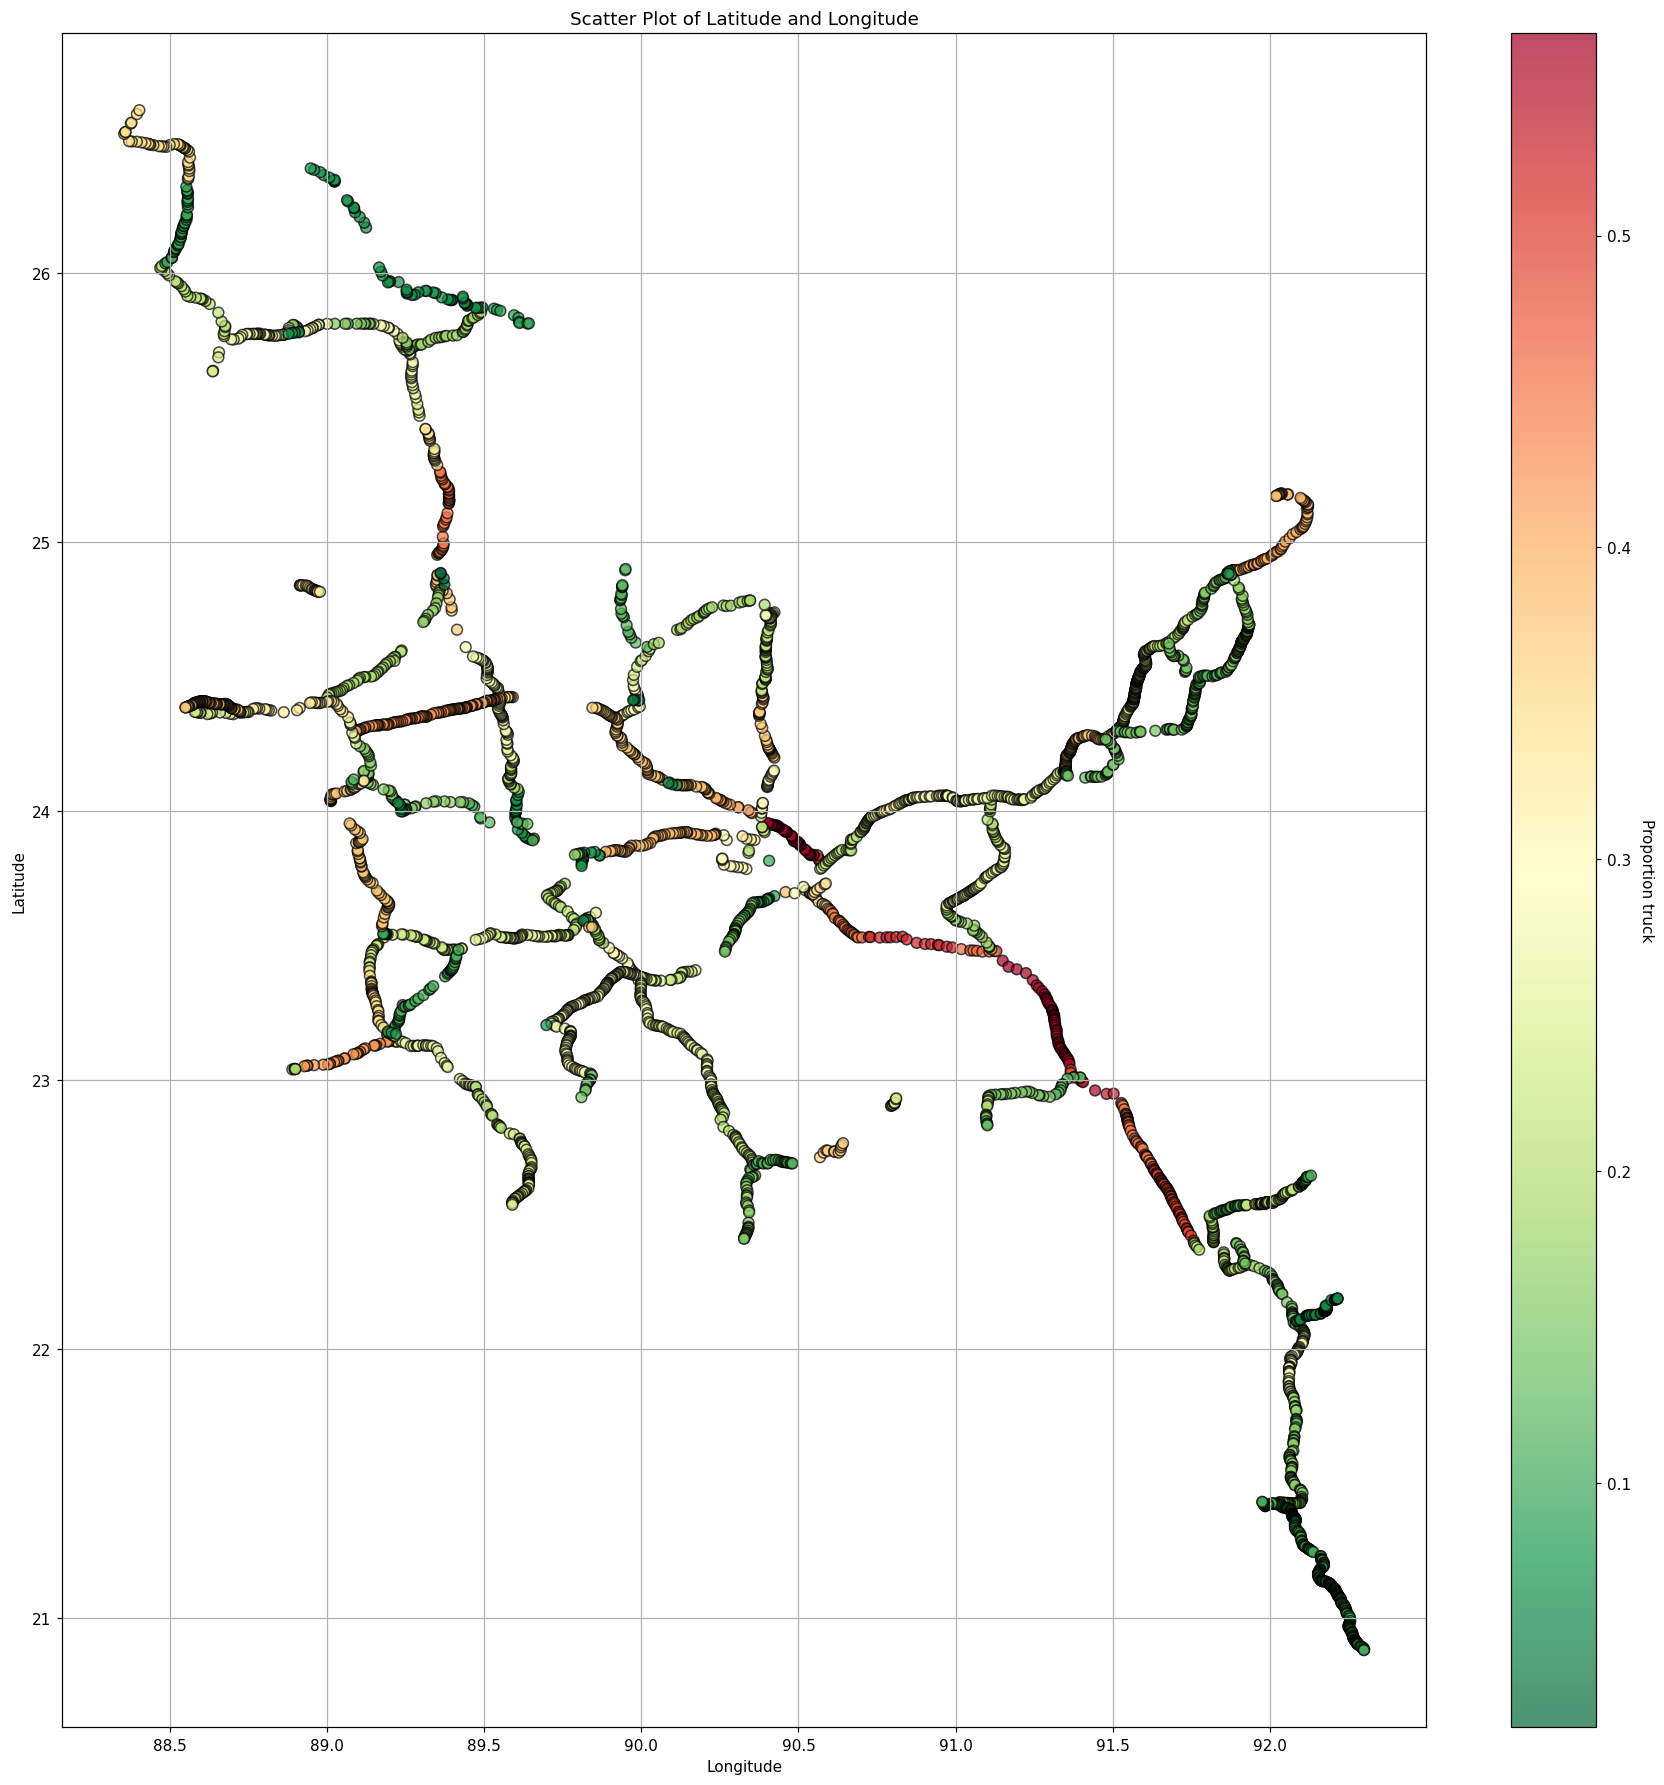

In [407]:
plot_road(bmms6,20)

In [364]:
def plot_bridge_quality(df, size=7, s=50):
    x = df['Proportion truck']  # Proportion of trucks driving over the bridges
    y = df['length']  # Length of the bridges
    c = df['condition'].map({'A': 'green', 'B': 'yellow', 'C': 'orange', 'D': 'red'})  # Color based on 'condition'
    
    fig, ax = plt.subplots(figsize=(size, size), dpi=110)   
    sc = ax.scatter(x, y, s=s, c=c, edgecolor='k', alpha=0.7)
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['green', 'yellow', 'orange', 'red']]
    labels = ['A', 'B', 'C', 'D']
    plt.legend(handles, labels, title='Bridge Quality', loc='upper right')
    
    plt.title('Scatter Plot of Proportion of Trucks and Bridge Length')
    plt.xlabel('Proportion of Trucks')
    plt.ylabel('Bridge Length')
    #plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.yscale('log')  # Set x-axis to logarithmic scale

    plt.grid(True)
    plt.show()

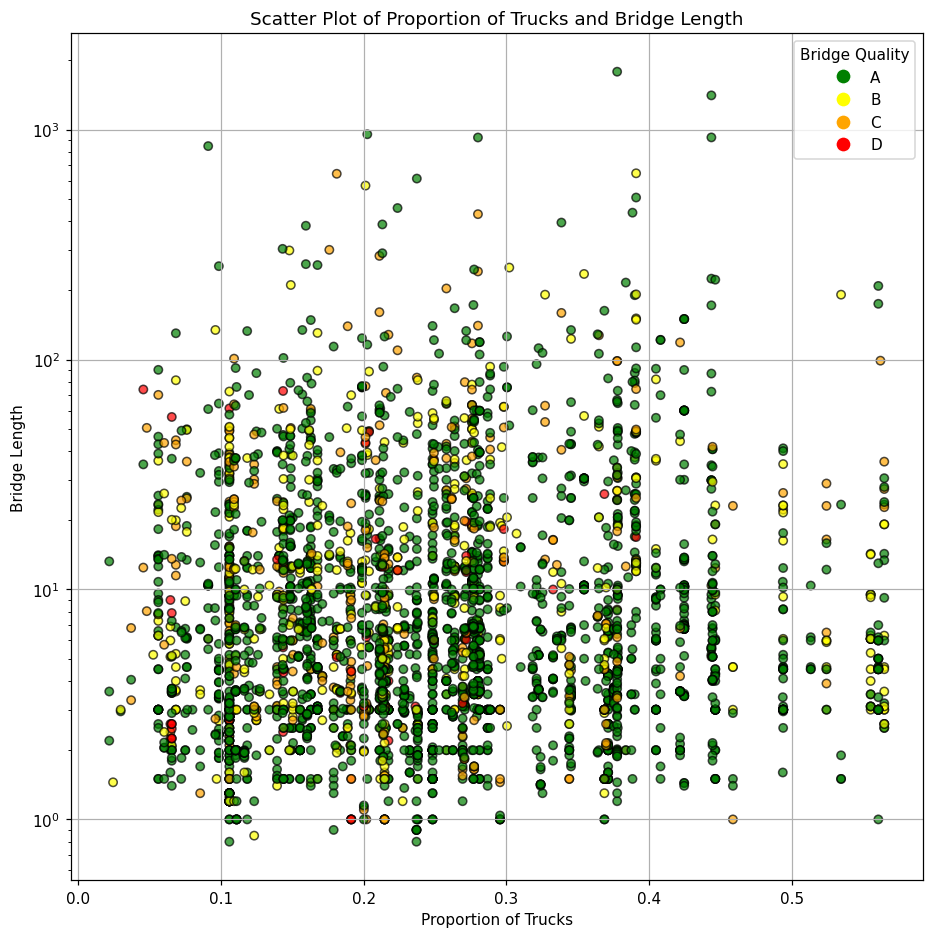

In [367]:
plot_bridge_quality(bmms6,size=10,s=30)

In [390]:
def plot_bridge_quality_histograms(df, size=7):
    qualities = ['A', 'B', 'C', 'D']
    colors = ['green', 'yellow', 'orange', 'red']
    
    fig, axs = plt.subplots(1, 4, figsize=(size*2, size), dpi=110, sharex=True)
    
    for i, quality in enumerate(qualities):
        subset_df = df[df['condition'] == quality]
        axs[i].hist(subset_df['Proportion truck'], bins=20, color=colors[i], alpha=0.7, edgecolor='black', density=True, orientation='horizontal')
        
        axs[i].set_title(f'Bridge Quality {quality}')
        axs[i].set_ylabel('Proportion of Trucks')
        axs[i].grid(True)
        
    axs[0].set_xlabel('Density')
    plt.tight_layout()
    plt.show()

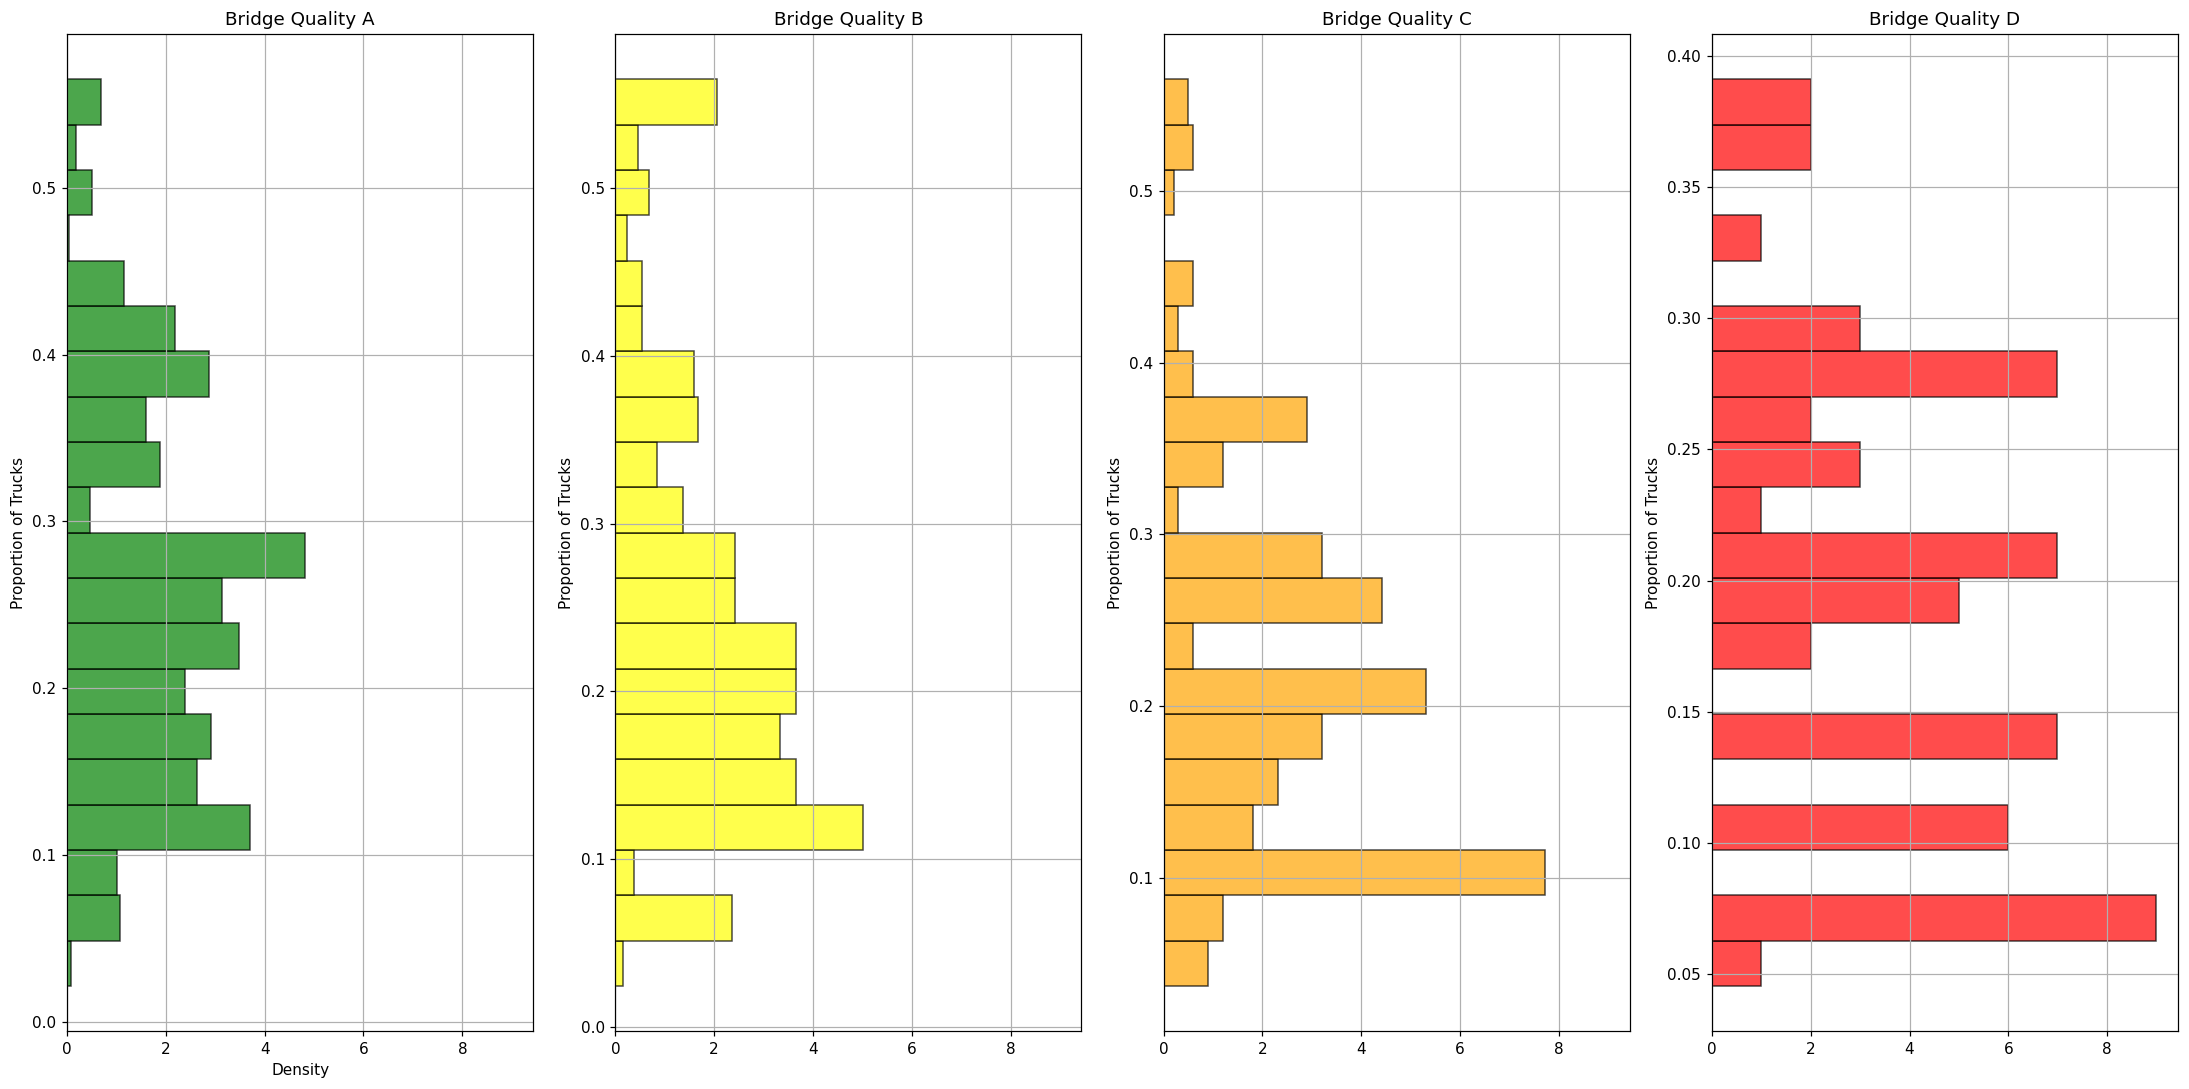

In [391]:
plot_bridge_quality_histograms(bmms6,size=10)

In [392]:
def plot_bridge_quality_lines(df, size=7):
    qualities = ['A', 'B', 'C', 'D']
    colors = ['green', 'yellow', 'orange', 'red']
    
    fig, ax = plt.subplots(figsize=(size, size), dpi=110)
    
    for i, quality in enumerate(qualities):
        subset_df = df[df['condition'] == quality]
        
        # Plot KDE curve
        sns.kdeplot(subset_df['Proportion truck'], color=colors[i], ax=ax, label=f'Bridge Quality {quality}')
        
    ax.set_title('Kernel Density Estimate of Proportion of Trucks by Bridge Quality')
    ax.set_xlabel('Proportion of Trucks')
    ax.set_ylabel('Density')
    ax.legend(title='Bridge Quality', loc='upper right')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

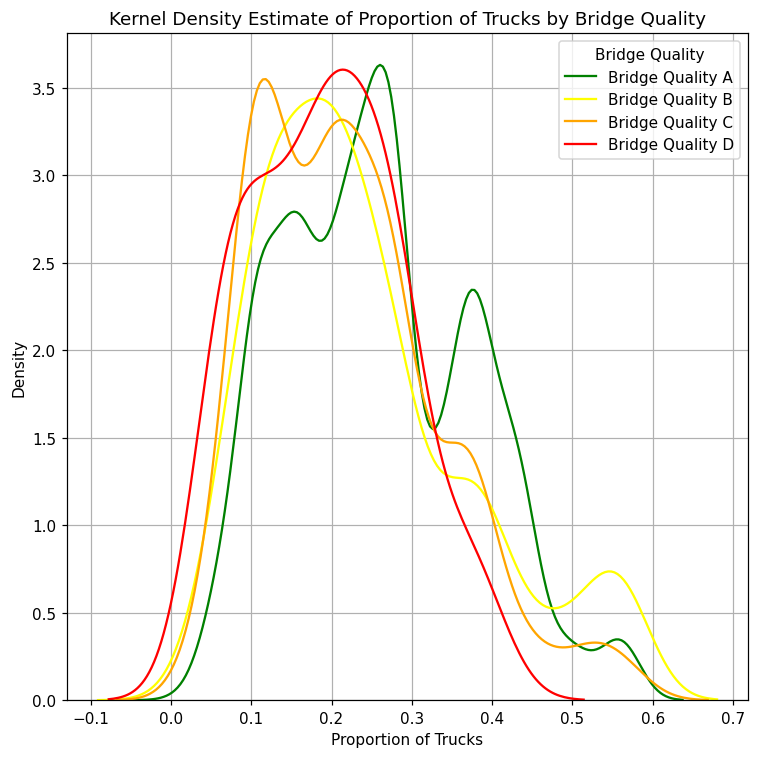

In [394]:
plot_bridge_quality_lines(bmms6)

In [403]:
def plot_average_proportion_truck(df, size=10):
    average_proportion = df.groupby('road')['Proportion truck'].mean() 
    
    fig, ax = plt.subplots(figsize=(size, size), dpi=110)
    average_proportion.plot(kind='bar', color='skyblue', ax=ax)
    
    ax.set_title('Average Proportion of Trucks by Road')
    ax.set_xlabel('Road')
    ax.set_ylabel('Average Proportion of Trucks')
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()

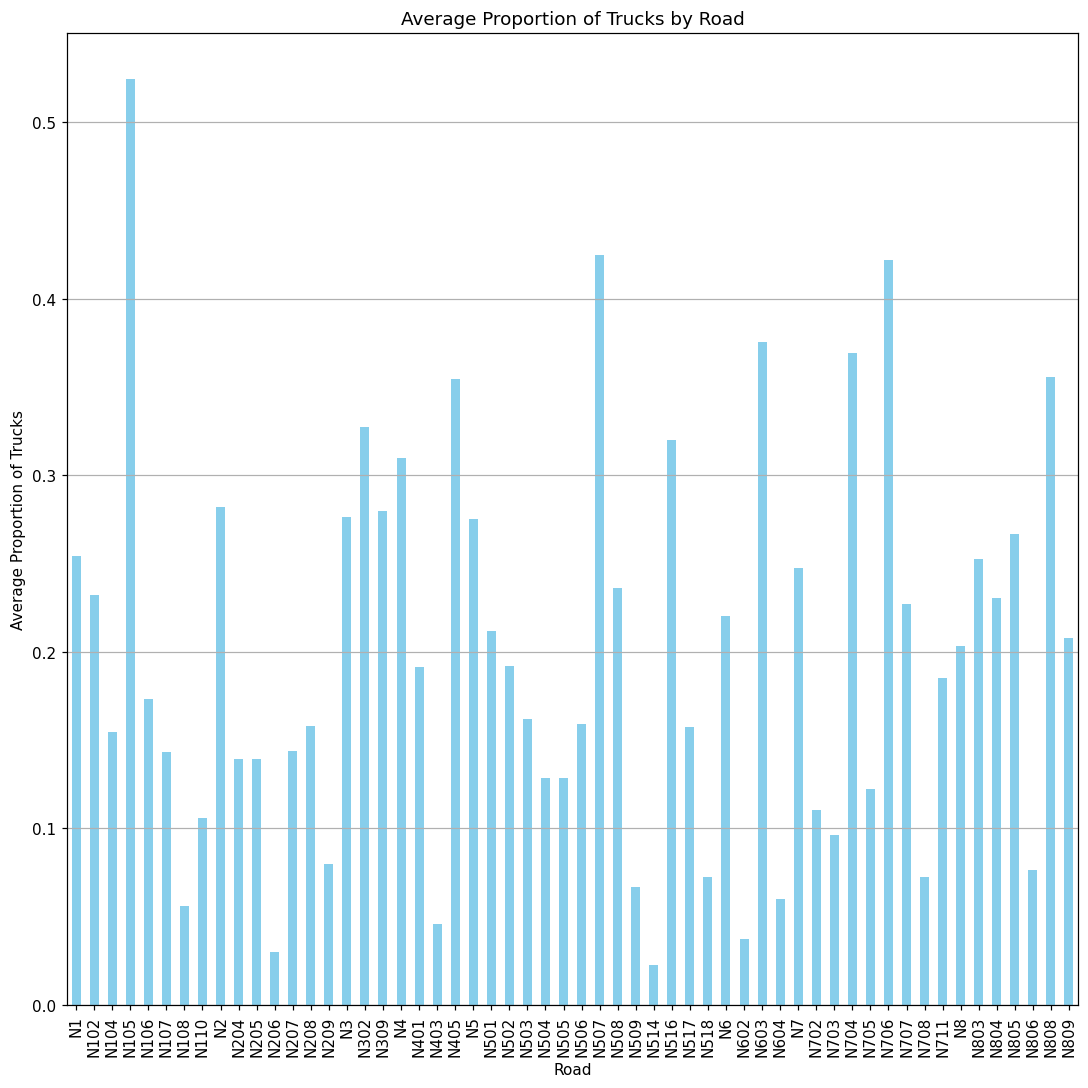

In [404]:
plot_average_proportion_truck(bmms6)